In [38]:
import numpy as np

# Init params

# Zadoff-Chu sequence params
# Length of sequence
N = 12
# Root index of sequence
r = 1
# Shift
SHIFT = 8

# Channel params
# Period of chip
T_c = 2
# Length sequence for chip
Nc = N
# Period of 
T_0 = T_c / 8
# Base frequnecy
f0 = 1 / T_0
# Sampling frequency / time step
dt = T_0 / 20
# Maximum possible number of sequences
tmpRe = int(T_c / dt)
tmpIm = int(T_c / dt)
# Signal duration
Ts = Nc * T_c
# Random phase shift
tetta = 2

# Timeline
t = np.arange(0, Ts, dt)

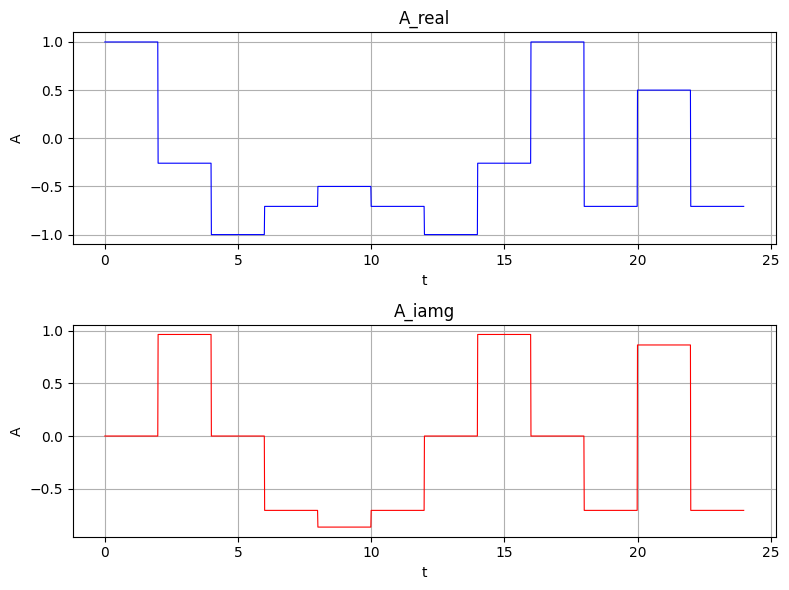

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import sdr

# Generate ZC-sequence
S1 = sdr.zadoff_chu_sequence(N, r, SHIFT)

# Phi functions
phi1 = lambda t: np.where((0 < t) & (t < np.sqrt(T_c)), (1 / T_c), 0)
phi2 = lambda t: np.where((0 < t) & (t < np.sqrt(T_c)), (1 / T_c), 0)

# Piecewise constant functions
ReZ = lambda t: np.sum([S1[n].real * phi1(t - n*T_c) for n in range(N)], axis=0)
ImZ = lambda t: np.sum([S1[n].imag * phi1(t - n*T_c) for n in range(N)], axis=0)

# Преобразуем матрицы в вектора
ReZ_values_reverse = np.repeat(S1.real, tmpRe)
ImZ_values_reverse = np.repeat(S1.imag, tmpIm)
ReZ_values = np.repeat(S1.real, tmpRe)
ImZ_values = np.repeat(S1.imag, tmpIm)



plt.figure(figsize=(8, 6))

# График ReZ_values
plt.subplot(2, 1, 1)
plt.plot(t, ReZ_values, color='blue', linewidth=0.8)
plt.title('A_real')
plt.xlabel('t')
plt.ylabel('A')
plt.grid(True)

# График ImZ_values
plt.subplot(2, 1, 2)
plt.plot(t, ImZ_values, color='red', linewidth=0.8)
plt.title('A_iamg')
plt.xlabel('t')
plt.ylabel('A')
plt.grid(True)

plt.tight_layout()
plt.show()

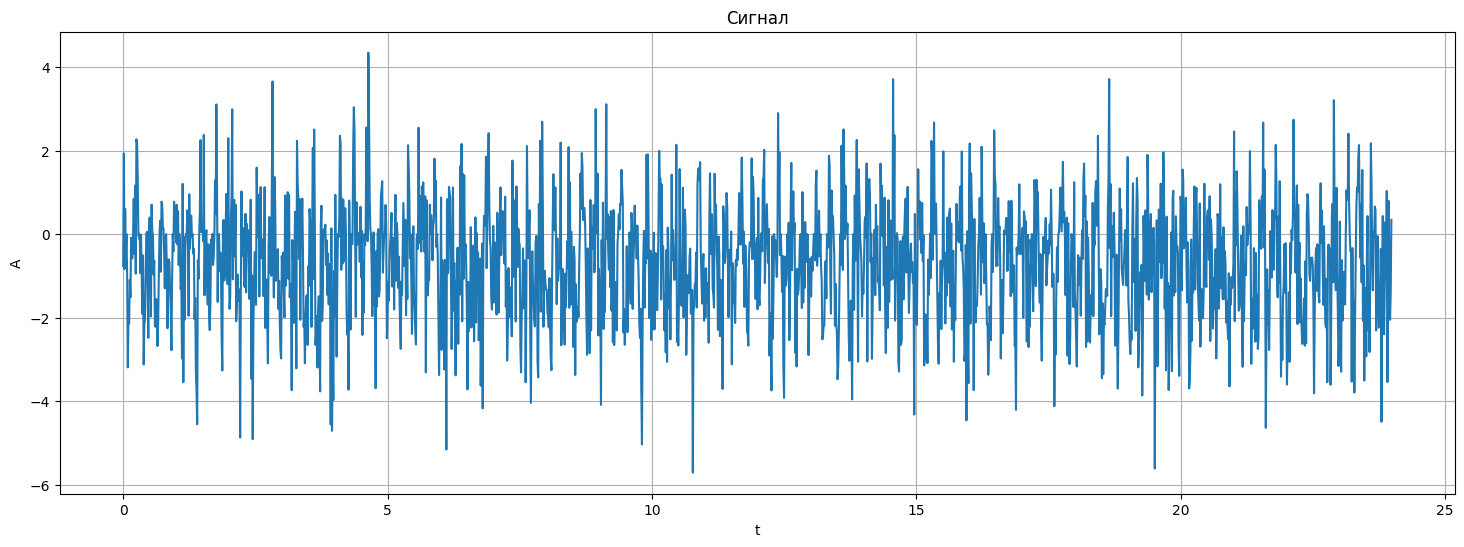

In [40]:
import matplotlib.pyplot as plt

Y_dB = 1
SNR = 10**(Y_dB/10)
sigma = np.sqrt(np.abs(1/(2 * SNR) * (ReZ_values * np.cos(2*np.pi*f0*t))))
sigma1 = np.sqrt(np.abs(1/(2 * SNR) * (ImZ_values * np.sin(2*np.pi*f0*t))))
noise = sigma * (np.random.randn(len(t)) * 2 - 1) + sigma1 * (np.random.randn(len(t)) * 2 - 1)

# Generate signal
Stz = ReZ_values * np.cos(2 * np.pi * f0 * t) + ImZ_values * np.sin(2 * np.pi * f0 * t)
# Add noise
Stz += noise


reverse_sin = Stz * np.cos(2 * np.pi * f0 * t)
reverse_cos = Stz * np.sin(2 * np.pi * f0 * t)

plt.figure(figsize=(18, 6))
plt.plot(t, Stz)
plt.title('Сигнал')
plt.xlabel('t')
plt.ylabel('A')
plt.grid(True)

plt.show()

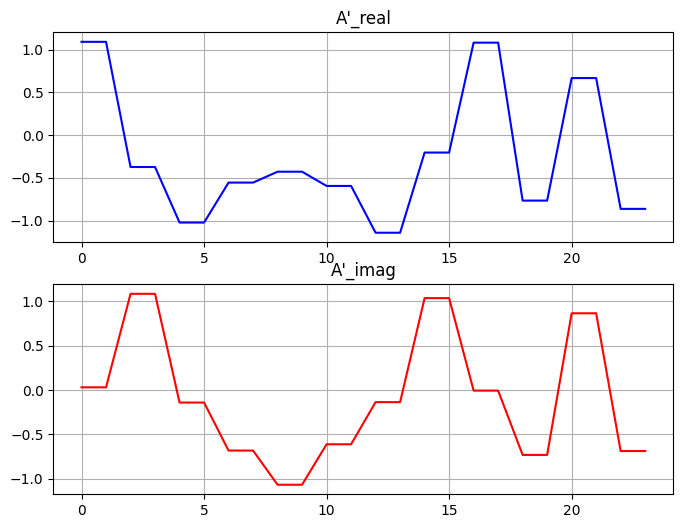

In [41]:
interval_re = []
interval_im = []

for i in range(N):
  integral_reverse_sin = np.trapz(reverse_sin[i*tmpRe:i*tmpRe + tmpRe], x=t[i:i + tmpRe])
  integral_reverse_cos = np.trapz(reverse_cos[i*tmpIm:i*tmpIm + tmpIm], x=t[i:i + tmpIm])
  interval_re.append(integral_reverse_sin)
  interval_im.append(integral_reverse_cos)


plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
plt.plot(np.repeat(interval_re, 2), color='b')
plt.title('A\'_real')
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(np.repeat(interval_im, 2), color='r')
plt.title('A\'_imag')
plt.grid(True)

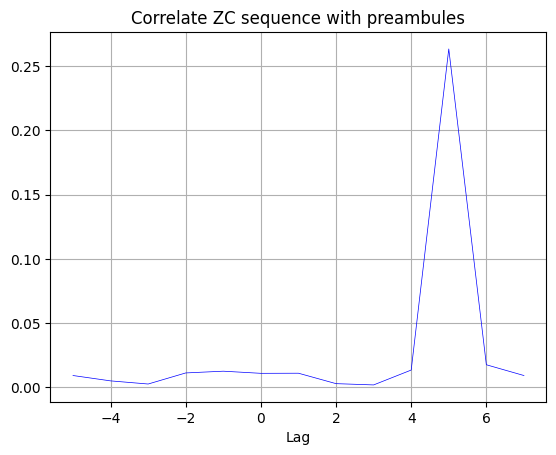

In [42]:
import numpy as np
from matplotlib import pyplot as plt
import sdr

# Treshhold
TRH = 0.99

# Recived sequence
recived = np.vectorize(complex)(interval_re, interval_im)

# Generate ZC
SEQUENCE_A = sdr.zadoff_chu_sequence(N, r)
L = len(SEQUENCE_A)
xcorr = np.correlate(np.roll(np.tile(recived, 2), -N//2), SEQUENCE_A, mode="valid")  
# xcorr_i = np.correlate(np.roll(np.tile(SEQUENCE_1, 2), -N//2), sequence_shifted, mode="valid")
lag = np.arange(-N//2 + 1, N//2 + 2)  

# print (abs(xcorr))

plt.figure()
# plt.plot(lag, (np.abs(xcorr + xcorr1) + noise) / L, label='s(t) + n(t)', color='r', linewidth=1, markersize=3)
plt.plot(lag, np.abs(xcorr) / (2 * L), color='b', linewidth=0.5, markersize=3)
plt.xlabel("Lag")
plt.title(f"Correlate ZC sequence with preambules")
plt.grid()
plt.show()